# Spam Detection

This code is based on an assignment developed by Prof. Lisa Zhang.

## LSTM from Scratch

In this part I will construct a LSTM model for identifying spam from non spam messages.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

### Data Cleaning

I will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [ ]:
for line in open('SMSSpamCollection'):
  if "ham" in line:
    s1=line
    print(line)
    break

for line in open('SMSSpamCollection'):
  if "spam" in line:
    print(line)
    break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



The label value for a spam message is "spam" and the label value for a non-spam message is "ham".

**Number of spam messages:**

In [ ]:
spam_messages_num=0
for line in open('SMSSpamCollection'):
  if (line.split(None, 1)[0]=="spam"):
    spam_messages_num=spam_messages_num+1

print("There are", spam_messages_num, "spam messages")

There are 747 spam messages


**Number of non-spam messages:**

In [ ]:
non_spam_messages_num=0
for line in open('SMSSpamCollection'):
  if (line.split(None, 1)[0]=="ham"):
    non_spam_messages_num=non_spam_messages_num+1

print("There are", non_spam_messages_num, "non-spam messages")

There are 4827 non-spam messages


I will be loading the data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

I will split the dataset into 60% training, 20% validation, and 20% testing.

In [ ]:
import torchtext
import random

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

#dataset[0].sms
#dataset[0].label
train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2],random_state=random.getstate())

There are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Building Vocabulary

In [ ]:
text_field.build_vocab(train)

In [ ]:
text_field.vocab.stoi

text_field.vocab.stoi represents a collection of the characters with a corresponding numerical value that identifies where each character - that torchtext has found in the sentences - is located in the new vocabulary (our training data).  

In [ ]:
text_field.vocab.itos

text_field.vocab.itos represents a collection of the characters indexed in the order of the numerical values (found in text_field.vocab.stoi) in the new vocabulary that torchtext has found in the sentences (our training data).

The token `<unk>` represents unknown or unseen characters in our vocabulary (out of vocabulary), while `<pad>` means adding padding token before or after a character to allow sentences' lengths to match.

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
i=0
for batch in train_iter:
  count=0
  if i<=9:
    #print(batch.sms[1])
    print("The maximum length of input sequence in batch", i+1, "is:", np.array(torch.max(batch.sms[1]))) 
    for j in range(len(batch.sms[0])):
      count=count+np.count_nonzero(np.array(batch.sms[0][j])==1) #pad token has index of 1
    print("The number of times <pad> token was used in batch",i+1,"is:",count)
  else:
    break
  i=i+1
  print()

The maximum length of input sequence in batch 1 is: 156
The number of times <pad> token was used in batch 1 is: 0

The maximum length of input sequence in batch 2 is: 148
The number of times <pad> token was used in batch 2 is: 21

The maximum length of input sequence in batch 3 is: 52
The number of times <pad> token was used in batch 3 is: 15

The maximum length of input sequence in batch 4 is: 152
The number of times <pad> token was used in batch 4 is: 29

The maximum length of input sequence in batch 5 is: 42
The number of times <pad> token was used in batch 5 is: 34

The maximum length of input sequence in batch 6 is: 23
The number of times <pad> token was used in batch 6 is: 26

The maximum length of input sequence in batch 7 is: 36
The number of times <pad> token was used in batch 7 is: 22

The maximum length of input sequence in batch 8 is: 68
The number of times <pad> token was used in batch 8 is: 54

The maximum length of input sequence in batch 9 is: 136
The number of times <p

### Model Building

I will build a recurrent neural network model using the one-hot embedding of each character as input to the recurrent network.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

In [ ]:
def one_hot_encoding_embedding_build(x):
  text_field.build_vocab(train)
  ident = torch.eye(len(text_field.vocab.stoi))
  for i in range(0,len(x)):
      a = ident[x[i]].unsqueeze(0)
      if i==0:
        a_new=a
      else:
        a_new=torch.cat((a_new,a),dim=0)
  return a_new

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.emb = one_hot_encoding_embedding_build
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(torch.max(out, dim=1)[0])
        return out

In [ ]:
model=RNN(len(text_field.vocab.stoi),50,2)

### Training

In [ ]:
valid_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
def get_accuracy(model, data):
    correct, total = 0, 0
    for batch in data:
      length=len(batch)
      y=batch.sms[0]
      label=batch.label
      output = model(y)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(label.view_as(pred)).sum().item()
      total += length
    return correct/total

In [ ]:
import matplotlib.pyplot as plt

def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for batch in train:
            optimizer.zero_grad()
            pred = model(batch.sms[0])
            loss = criterion(pred, batch.label)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.699834; Train Acc 0.535528; Val Acc 0.178475
Epoch 2; Loss 0.644039; Train Acc 0.876365; Val Acc 0.844843
Epoch 3; Loss 0.285819; Train Acc 0.897867; Val Acc 0.947085
Epoch 4; Loss 0.360811; Train Acc 0.933983; Val Acc 0.904933
Epoch 5; Loss 0.196382; Train Acc 0.940198; Val Acc 0.941704
Epoch 6; Loss 0.218667; Train Acc 0.938350; Val Acc 0.957848
Epoch 7; Loss 0.204333; Train Acc 0.947421; Val Acc 0.922870
Epoch 8; Loss 0.197924; Train Acc 0.952965; Val Acc 0.939013
Epoch 9; Loss 0.137086; Train Acc 0.952293; Val Acc 0.958744
Epoch 10; Loss 0.109422; Train Acc 0.952125; Val Acc 0.959641
Epoch 11; Loss 0.058031; Train Acc 0.957836; Val Acc 0.942601
Epoch 12; Loss 0.098960; Train Acc 0.957500; Val Acc 0.958744
Epoch 13; Loss 0.092481; Train Acc 0.954309; Val Acc 0.964126
Epoch 14; Loss 0.061649; Train Acc 0.950445; Val Acc 0.965022
Epoch 15; Loss 0.115757; Train Acc 0.951957; Val Acc 0.965022
Epoch 16; Loss 0.018911; Train Acc 0.952797; Val Acc 0.926457
Epoch 17; Loss 0.

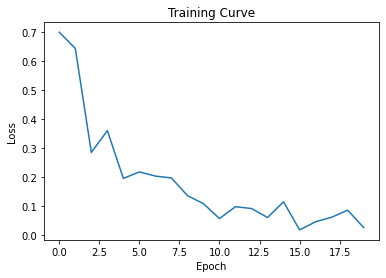

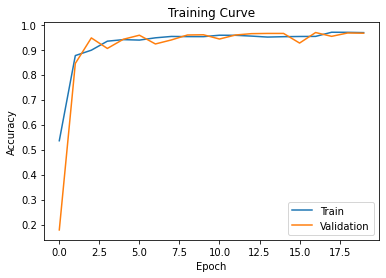

In [ ]:
train_rnn_network(model, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

### Hyperparameter Tuning

**Hyperparameter tuning 1: Increasing Batch Size**

I will try increasing the batch size, which is supposed to increase the accuracy of our model.

In [ ]:
train_iter2 = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
valid_iter2 = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
model2=RNN(len(text_field.vocab.stoi),50,2)

Epoch 1; Loss 0.696584; Train Acc 0.646878; Val Acc 0.814350
Epoch 2; Loss 0.677773; Train Acc 0.859025; Val Acc 0.899552
Epoch 3; Loss 0.676679; Train Acc 0.907442; Val Acc 0.924664
Epoch 4; Loss 0.669713; Train Acc 0.944910; Val Acc 0.954260
Epoch 5; Loss 0.592694; Train Acc 0.916510; Val Acc 0.958744
Epoch 6; Loss 0.450528; Train Acc 0.880924; Val Acc 0.926457
Epoch 7; Loss 0.330012; Train Acc 0.915654; Val Acc 0.854709
Epoch 8; Loss 0.366223; Train Acc 0.910351; Val Acc 0.907623
Epoch 9; Loss 0.314143; Train Acc 0.892729; Val Acc 0.964126
Epoch 10; Loss 0.201526; Train Acc 0.935158; Val Acc 0.956054
Epoch 11; Loss 0.127030; Train Acc 0.942344; Val Acc 0.954260
Epoch 12; Loss 0.245050; Train Acc 0.941831; Val Acc 0.921973
Epoch 13; Loss 0.192180; Train Acc 0.941831; Val Acc 0.959641
Epoch 14; Loss 0.260718; Train Acc 0.945766; Val Acc 0.944395
Epoch 15; Loss 0.109240; Train Acc 0.912575; Val Acc 0.971300
Epoch 16; Loss 0.227271; Train Acc 0.937382; Val Acc 0.969507
Epoch 17; Loss 0.

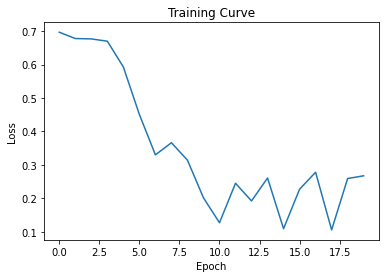

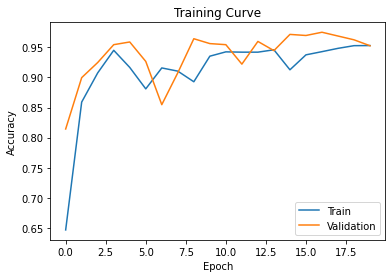

In [ ]:
train_rnn_network(model2, train_iter2, valid_iter2, num_epochs=20, learning_rate=1e-4)

**Hyperparameter tuning 2: LSTM**

The reason why I chose to use LSTM instead of RNN is because it might increase the accuracy by tackling the diminishing gradient issue. However, this is more computationally expensive.

In [ ]:
class RNN3(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN3, self).__init__()
        self.emb = one_hot_encoding_embedding_build
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, (h0,c0))
        out = self.fc(torch.max(out, dim=1)[0])
        return out

In [ ]:
model3=RNN3(len(text_field.vocab.stoi),50,2)

Epoch 1; Loss 0.744967; Train Acc 0.488493; Val Acc 0.862780
Epoch 2; Loss 0.684952; Train Acc 0.836049; Val Acc 0.947085
Epoch 3; Loss 0.263320; Train Acc 0.934151; Val Acc 0.921973
Epoch 4; Loss 0.521875; Train Acc 0.918025; Val Acc 0.966816
Epoch 5; Loss 0.557541; Train Acc 0.921384; Val Acc 0.965022
Epoch 6; Loss 0.506237; Train Acc 0.919200; Val Acc 0.971300
Epoch 7; Loss 0.133794; Train Acc 0.919200; Val Acc 0.971300
Epoch 8; Loss 0.182170; Train Acc 0.921888; Val Acc 0.962332
Epoch 9; Loss 0.261686; Train Acc 0.916009; Val Acc 0.969507
Epoch 10; Loss 0.353247; Train Acc 0.915001; Val Acc 0.970404
Epoch 11; Loss 0.281820; Train Acc 0.904082; Val Acc 0.967713
Epoch 12; Loss 0.516990; Train Acc 0.917353; Val Acc 0.971300
Epoch 13; Loss 0.054380; Train Acc 0.918864; Val Acc 0.971300
Epoch 14; Loss 0.305954; Train Acc 0.935327; Val Acc 0.965022
Epoch 15; Loss 0.141524; Train Acc 0.919536; Val Acc 0.972197
Epoch 16; Loss 0.193883; Train Acc 0.917185; Val Acc 0.972197
Epoch 17; Loss 0.

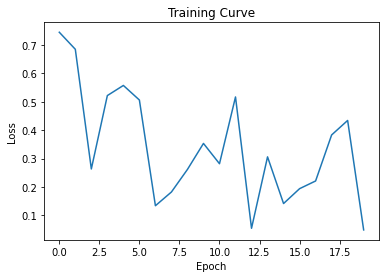

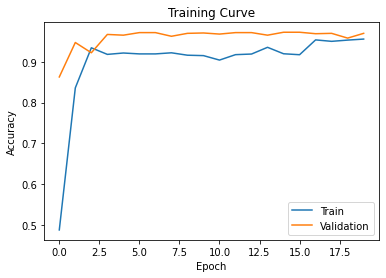

In [ ]:
train_rnn_network(model3, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

**Hyperparameter tuning 3: GRU**

The reason why I chose to try GRU is because it is now more common than LSTM, and still helps to improve the accuracy but without adding the cell state, making it less computationally expensive than LSTM.

In [ ]:
class RNN4(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN4, self).__init__()
        self.emb = one_hot_encoding_embedding_build
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(torch.max(out, dim=1)[0])
        return out

In [ ]:
model4=RNN4(len(text_field.vocab.stoi),50,2)

Epoch 1; Loss 0.769966; Train Acc 0.511507; Val Acc 0.137220
Epoch 2; Loss 0.718627; Train Acc 0.512515; Val Acc 0.138117
Epoch 3; Loss 0.701900; Train Acc 0.560390; Val Acc 0.236771
Epoch 4; Loss 0.382952; Train Acc 0.928607; Val Acc 0.906726
Epoch 5; Loss 0.113661; Train Acc 0.929111; Val Acc 0.942601
Epoch 6; Loss 0.472068; Train Acc 0.921384; Val Acc 0.958744
Epoch 7; Loss 0.354138; Train Acc 0.922056; Val Acc 0.965919
Epoch 8; Loss 0.257899; Train Acc 0.938182; Val Acc 0.944395
Epoch 9; Loss 0.229538; Train Acc 0.942550; Val Acc 0.936323
Epoch 10; Loss 0.263372; Train Acc 0.940870; Val Acc 0.947982
Epoch 11; Loss 0.393601; Train Acc 0.946246; Val Acc 0.941704
Epoch 12; Loss 0.112952; Train Acc 0.943222; Val Acc 0.943498
Epoch 13; Loss 0.399686; Train Acc 0.931463; Val Acc 0.953363
Epoch 14; Loss 0.402506; Train Acc 0.931967; Val Acc 0.955157
Epoch 15; Loss 0.123511; Train Acc 0.933143; Val Acc 0.954260
Epoch 16; Loss 0.377281; Train Acc 0.932471; Val Acc 0.955157
Epoch 17; Loss 0.

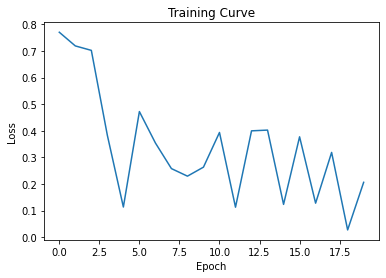

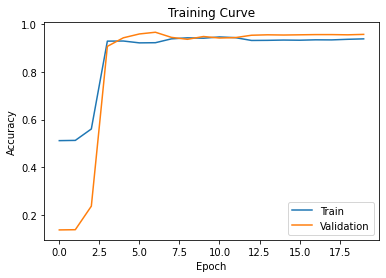

In [ ]:
train_rnn_network(model4, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

**Hyperparameter tuning 4: Increasing Hidden Size**

The reason why I am choosing to tune the hidden size is because we need to see how it changes the accuracy of the model, which is mostly done by trial and error. For this reason, I will increase it.

In [ ]:
model5=RNN(len(text_field.vocab.stoi),100,2)

Epoch 1; Loss 0.620101; Train Acc 0.737107; Val Acc 0.539013
Epoch 2; Loss 0.457190; Train Acc 0.913489; Val Acc 0.949776
Epoch 3; Loss 0.184086; Train Acc 0.930623; Val Acc 0.961435
Epoch 4; Loss 0.217576; Train Acc 0.931127; Val Acc 0.970404
Epoch 5; Loss 0.141415; Train Acc 0.948765; Val Acc 0.951570
Epoch 6; Loss 0.118933; Train Acc 0.942886; Val Acc 0.968610
Epoch 7; Loss 0.135151; Train Acc 0.946078; Val Acc 0.969507
Epoch 8; Loss 0.190780; Train Acc 0.954141; Val Acc 0.948879
Epoch 9; Loss 0.028864; Train Acc 0.958172; Val Acc 0.965022
Epoch 10; Loss 0.097437; Train Acc 0.958676; Val Acc 0.967713
Epoch 11; Loss 0.012273; Train Acc 0.958172; Val Acc 0.950673
Epoch 12; Loss 0.167477; Train Acc 0.964892; Val Acc 0.965919
Epoch 13; Loss 0.060267; Train Acc 0.962372; Val Acc 0.963229
Epoch 14; Loss 0.074609; Train Acc 0.968083; Val Acc 0.952466
Epoch 15; Loss 0.018452; Train Acc 0.969931; Val Acc 0.965919
Epoch 16; Loss 0.020536; Train Acc 0.958004; Val Acc 0.965919
Epoch 17; Loss 0.

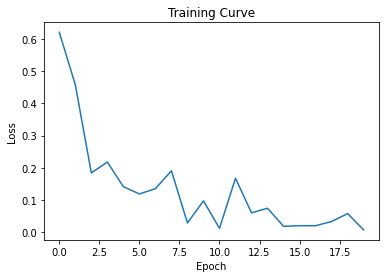

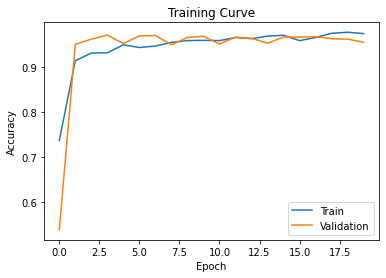

In [ ]:
train_rnn_network(model5, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

**Hyperparameter tuning 5: Pooling of RNN**

It is interesting to see the different effects of pooling the RNN, in the first method, I used the max pooling, but in this case we are just selecting the last token. I expect this will decrease the accuracy of the model, but want to test it to check.

In [ ]:
class RNN5(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN5, self).__init__()
        self.emb = one_hot_encoding_embedding_build
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model7=RNN5(len(text_field.vocab.stoi),30,2)

Epoch 1; Loss 0.663730; Train Acc 0.528315; Val Acc 0.766816
Epoch 2; Loss 0.654128; Train Acc 0.567836; Val Acc 0.775785
Epoch 3; Loss 0.715779; Train Acc 0.621386; Val Acc 0.705830
Epoch 4; Loss 0.685987; Train Acc 0.694782; Val Acc 0.713901
Epoch 5; Loss 0.596577; Train Acc 0.860907; Val Acc 0.878924
Epoch 6; Loss 0.625004; Train Acc 0.860393; Val Acc 0.797309
Epoch 7; Loss 0.292158; Train Acc 0.881779; Val Acc 0.845740
Epoch 8; Loss 0.667099; Train Acc 0.824979; Val Acc 0.925561
Epoch 9; Loss 0.410113; Train Acc 0.870145; Val Acc 0.940807
Epoch 10; Loss 0.220866; Train Acc 0.899572; Val Acc 0.943498
Epoch 11; Loss 0.080291; Train Acc 0.922669; Val Acc 0.931839
Epoch 12; Loss 0.217951; Train Acc 0.922327; Val Acc 0.942601
Epoch 13; Loss 0.266583; Train Acc 0.923695; Val Acc 0.943498
Epoch 14; Loss 0.354773; Train Acc 0.924038; Val Acc 0.941704
Epoch 15; Loss 0.391499; Train Acc 0.926775; Val Acc 0.933632
Epoch 16; Loss 0.477975; Train Acc 0.926604; Val Acc 0.935426
Epoch 17; Loss 0.

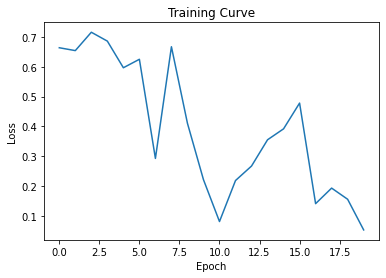

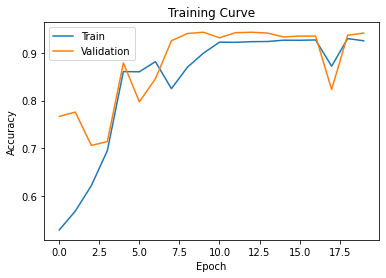

In [ ]:
train_rnn_network(model7, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

The model that gave us the highest validation accuracy was the one where I implemented nn.LSTM.

Before deploying a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
how well our model performs in certain subsets of the data.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

In [ ]:
valid_spam_iter=torchtext.legacy.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
FPR=get_accuracy(model, valid_spam_iter)

In [ ]:
print("The false positive rate of this model is:", 1-FPR)

The false positive rate of this model is: 0.042944785276073594


In [ ]:
valid_nospam_iter=torchtext.legacy.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
FNR=get_accuracy(model, valid_nospam_iter)

In [ ]:
print("The false negative rate of this model is:", 1-FNR)

The false negative rate of this model is: 0.03361344537815125


The effect of a false positive is not that alarming, because it would consider an sms that is not spam to be spam, and that could be retrieved. However, it could be inefficient because if we had an important sms that was sent to spam when it was actually not spam would disrupt some businesses.

On the other hand, the effect of a false negative is more dangerous, and this is where it would allow a spam sms to pass through, and that could lead to dangerous outcomes. So having a false negative rate of 0.033 could be considered good, but in this case it is actually dangerous. Consider a large company that receives thousands of emails per day, if out of every 100 spam emails it allows 3 to pass through, this is bad.

### Evaluation

In [ ]:
test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
test_accuracy=get_accuracy(model, test_iter)
print("The test accuracy of the model is:", test_accuracy)

The test accuracy of the model is: 0.9631956912028725


In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

In [ ]:
test_spam_iter=torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
FPR_test=get_accuracy(model, test_spam_iter)
print("The false positive rate on the test set is:", 1-FPR_test)

The false positive rate on the test set is: 0.04790419161676651


In [ ]:
test_nospam_iter=torchtext.legacy.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
FNR_test=get_accuracy(model, test_nospam_iter)
print("The false negative rate on the test set is:", 1-FNR_test)

The false negative rate on the test set is: 0.032734952481520585


Let us check what is the model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

In [ ]:
import math
msg = "machine learning is sooo cool!"

msg_new=list(tuple(msg))
msg_new2=[]
for i in enumerate(msg_new):
  msg_new2.append(text_field.vocab.stoi[i[1]])

msg_new2=torch.tensor(msg_new2).unsqueeze(0)
prob=model(msg_new2)
# pred=prob.max(1,keepdim=True)[1]
sigmoid1=1/(1+math.exp(-(prob[0][1].item())))
print("The model's prediction of the probability that the message is spam is:", sigmoid1)

The model's prediction of the probability that the message is spam is: 0.22250063478527038


Detecting spam is a difficult task because whenever new and more advanced algorithms are implemented to detect the spam messages, hackers are finding more tidious ways to send those spam messages, going unnoticed.

However, there have been many attempts to do these detections, among which are recurrent neural networks. But simpler models exist out there to detect spam, which do not require computationally expensive training.

There are several simple baseline models we could compare our recurrent neural network against, which could be methods of content based filtering, case base filtering, heuristic or rule based spam filtering, previous likeness based spam filtering, and adaptive spam filtering (https://www.sciencedirect.com/science/article/pii/S2405844018353404).

The method that I think would be good to compare the RNN to is spam detection using support vector machines, which is a supervised learning method. Support vector machines are linear classifiers that aim to separate spam and non-spam emails by the optimal margin.

The way we would build the simple baseline model is the following:

1. Load the dataset containing the spam/ham emails (make sure the labels and emails are in separate dataframes).
2. Split data into training, validation and testing.
3. Convert the text to integers using CountVectorizer() from sklearn (similar to one hot encoding).
4. Perform support vector classification using SVC from sklearn, which is basically finding the best margin that separates the different classes of spam/non-spam.

Helper code: https://becominghuman.ai/spam-mail-detection-using-support-vector-machine-cdb57b0d62a8

This method is still a frequently used way to detect spam and is being improved in some researches (https://link.springer.com/article/10.1007/s00521-017-3100-y).


## Transfer Learning

In this part, I will compare the earlier model with one that takes advantage of a generative RNN model to improve the prediction. There are several ways to implement transfer learning with RNNs, here I will use an approach known as ULMFiT developed by fastai. Rather than rebuilding the model from scratch, we will take advantage of the fastai library.

#### Helper Code

In [ ]:
# install relevant libraries
!pip install fastai

In [ ]:
# load relevant libraries
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [ ]:
# download SPAM data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2021-11-23 02:53:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K  --.-KB/s    in 0.1s    

2021-11-23 02:53:29 (1.75 MB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SMSSpamCollection       
  inflating: readme                  


This time we will load the data using pandas.

In [ ]:
# set up data and verify
df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# check distribution
df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [ ]:
# # split the data and check dimensions

# from sklearn.model_selection import train_test_split

# # split data into training and validation set
# df_trn, df_val = train_test_split(df1, stratify = df1['target'], test_size = 0.3, random_state = 999)

In [ ]:
# df_trn.shape, df_val.shape

((3900, 2), (1672, 2))

In [ ]:
def convert_to_pd(data):
  arr_targets=np.zeros(len(data))
  arr_texts=np.empty([len(data)],dtype="<U100")

  for i in range(0,len(data)):
    arr_targets[i]=vars(data[i]).get('label')
    arr_texts[i]=vars(data[i]).get('sms')
    df=pd.DataFrame({'target': arr_targets, 'text': arr_texts})
  return df

df_train=convert_to_pd(train)
df_val=convert_to_pd(valid)
df_test=convert_to_pd(test)

In [ ]:
def change_classes(df):
  df.loc[(df['target']==0.0),'target']="ham"
  df.loc[(df['target']==1.0),'target']="spam"
  return df

df_train=change_classes(df_train)
df_val=change_classes(df_val)
df_test=change_classes(df_test)

### Create the language model
Esentially, the language model contains the structure of the language (English in this case), allowing us to quickly use in a classification model, skipping the part of learning the semantics of the language from scratch.

Creating a language model from scratch can be intensive due to the sheer size of data. Instead we will download the pre-trained model, which is a neural network (NN) with an AWD_LSTM architecture. By setting pretrained = True we say to fastai to download the weights from the trained model (a corpus of 103 MM of wikipedia articles).

In [ ]:
# create pretrained language model data
data_lm = TextLMDataBunch.from_df(train_df = df_train, valid_df = df_val, path = "")
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


### Testing the language model


In [ ]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when moving is the time of a year , however it
The problem usually starts when sleeping on a black pie , however , the idea
The problem usually starts when in space , however it can be quite painful on
The problem usually starts when it is made possible to take a real moment ,
The problem usually starts when it can be used to plan new sex again .


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

Try your own sentences!

### Fine-tuning the language model
The language model that we have "loaded" is great for generating wikipedia-like sentances, but here we're more interested in generating data like our email dataset. 

Make sure to enable GPU for this step or it make takes several hours to train.

In [ ]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,5.131147,4.374558,0.242857,00:02
1,3.902808,4.341823,0.228571,00:02
2,3.219813,4.544222,0.228571,00:02
3,2.817692,4.546724,0.214286,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.386116,4.586669,0.200000,00:02
1,2.335784,4.472074,0.200000,00:02
2,2.295069,4.475451,0.200000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.204671,4.468325,0.200000,00:02
1,2.156487,4.456062,0.214286,00:02
2,2.119183,4.456776,0.214286,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.057080,4.433301,0.214286,00:03
1,2.020641,4.415503,0.214286,00:03
2,1.994403,4.410829,0.214286,00:03


### Classification model
Now we can train a classification model that will identify spam and non-spam messages. Since we used a fastai language model, it will be easier to just continue working with the fastai library.

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_train,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
"xxbos xxup hey xxup babe ! xxup far 2 xxup xxunk - xxup out 2 xxup spk xxup at xxup da xxup mo ... xxup dead 2 xxup da xxup xxunk . xxup been xxup sleeping xxup on xxup da xxup sofa xxup all xxup day , xxup had a c",ham
xxbos xxup so xxup is xxup th xxup xxunk xxup mate xxup which xxup is xxup where i xxup am ! ? ! xxup how r u xxup man ? xxup all xxup is xxup good xxup in xxup xxunk xxup ill b xxup back xxup xxunk . c u,ham
xxbos xxup hiya xxup xxunk xxup wot u xxup up xxup xxunk xxup in xxup so xxup much xxup xxunk xxup at xxup home xxup at xxup moment xxup xxunk xxup xxunk xxup me xxup even u ! xxup wot xxup the xxup hell xxup xxunk i,ham
xxbos xxup hi xxup babe u r xxup most xxup xxunk xxup to xxup be xxup in xxup bed xxup but xxup im xxup so xxup sorry xxup about xxup tonight ! i xxup really xxup wanna xxup see u xxup tomorrow xxup so,ham
"xxbos xxup urgent , xxup important xxup information xxup for xxup o2 xxup user . xxup today xxup is xxup your xxup lucky xxup day ! 2 xxup find xxup out xxup why xxup log xxup onto xxup http : / / w",spam


In [ ]:
# create the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [ ]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5953 items)
x: TextList
xxbos xxmaj whenevr ur sad , xxmaj whenevr ur xxunk , xxmaj remembr i m here 2 xxunk 2 xxunk u wanna say , xxmaj jus walk wid me a lit,xxbos xxmaj how i noe ... xxmaj did ü xxunk da xxunk as xxunk ... ü still in sch ...,xxbos xxmaj aight , i 'll ask a few of my xxunk,xxbos xxmaj thanks for loving me so . xxmaj you rock,xxbos xxmaj ca n't . i feel xxunk . i 'm so pissed . i did n't eat any sweets all week cause today i was planning t
y: CategoryList
ham,ham,ham,ham,ham
Path: .;

Valid: LabelList (1115 items)
x: TextList
xxbos xxmaj want to finally have lunch today ?,xxbos xxmaj ur xxup xxunk subscription has been xxunk and you have been charged £ 4.50 . xxmaj you can choose 10 more poly,xxbos xxmaj ever green quote ever told by xxmaj xxunk in xxunk " a xxmaj person xxmaj who xxmaj xxunk u xxmaj always xxmaj is the one xxmaj who xxmaj loves,xxbos xxmaj are you coming to day for class .,xxbos xxmaj yo my trip go

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 5.75E-03


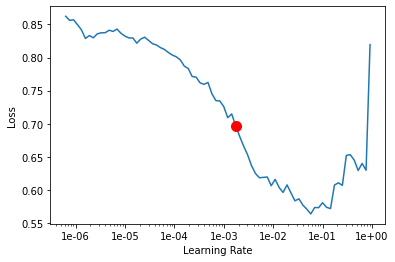

In [ ]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.356488,0.097671,0.968610,00:03
1,0.274261,0.186039,0.973991,00:03
2,0.149730,0.147160,0.974888,00:02
3,0.111370,0.176638,0.977578,00:03
4,0.115223,0.206834,0.980269,00:02


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

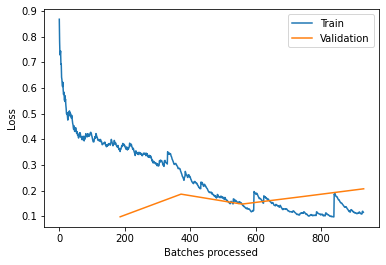

In [ ]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 2.51E-06


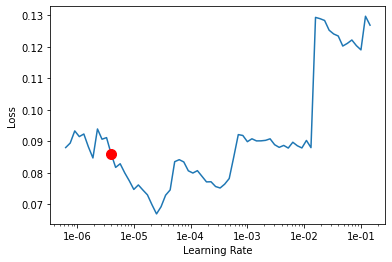

In [ ]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Test out the classification model on spam and non-spam examples.

In [ ]:
# predict
learn_classifier.predict('did you buy the groceries for dinner? :)')

(Category tensor(0), tensor(0), tensor([1.0000e+00, 1.3899e-12]))

In [ ]:
# predict
learn_classifier.predict('Free entry call back now')

(Category tensor(0), tensor(0), tensor([0.8416, 0.1584]))

Next we will evaluate on all of our validation data.

In [ ]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([1115, 2])

### Evaluate Performance

The accuracy is 0.980269, which is slightly higher than the accuracy obtained in the first part using only LSTM (we had 0.971300).

**Confusion Matrix for ULMFiT:**

In [ ]:
pred_label=torch.max(valid_preds,1)[1]

In [ ]:
from sklearn.metrics import confusion_matrix

cm1=confusion_matrix(list(valid_label),list(pred_label))

In [ ]:
cm1

array([[958,   4],
       [ 18, 135]])

**Confusion Matrix for only LSTM:**

Since the model that gave us the best validation accuracy was from model3, I will set model=model3

In [ ]:
model=model3

In [ ]:
valid_iter3= torchtext.legacy.data.BucketIterator(df_val,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
k=0
for i in valid_iter:
  if k==0:
    valid_label_partA=i.label
  else:
    valid_label_partA=torch.cat((valid_label_partA,i.label),0)
  k+=1

In [ ]:
def get_cm(model, data):
    k=0
    for batch in data:
      y=batch.sms[0]
      label=batch.label
      output = model(y)
      pred = output.max(1, keepdim=True)[1]
      if k==0:
        valid_pred_partA=pred.reshape(1,-1)[0]
      else:
        valid_pred_partA=torch.cat((valid_pred_partA,pred.reshape(1,-1)[0]),0)
      k+=1
    return valid_pred_partA

In [ ]:
valid_pred_partA=get_cm(model,valid_iter)

In [ ]:
cm2=confusion_matrix(list(valid_label_partA),list(valid_pred_partA))

In [ ]:
cm2

array([[785, 177],
       [ 16, 137]])

The ULMFiT is obviously doing better than the model with only LSTM, we can see qualitatively that the accuracy is higher. The qualitative difference is that the LSTM is performing better for detecting the spam messages while the ULMFiT is performing better in detecting the non-spam messages. If we look at the false positive rate ULMFiT is performing way better, if we look at the false negative rate, only LSTM is performing better.

### Evaluate on New Data

In [ ]:
k=learn_classifier.predict('machine learning is sooo cool!')

In [ ]:
print("The model's prediction of the probability that the message is spam is:", k[2][1].item())

The model's prediction of the probability that the message is spam is: 9.270281152215358e-16


I will load 5 sample sentences from random spam mail and test it out out the two models I created to check how well they perform.

**ULMFiT:**

In [ ]:
msgs_spam_partB=['Dear valued member, you won a free trip to Maldives!', 'URGENT, PLEASE HELP! I am stranded on a desert island, send 100000$', 'BRAND NEW APP ON THIS LINK, only pay 3$!', 'ITS YOUR CHANCE to win 100$ in bitcoin', 'LIMITED TIME OFFER call to be the first to get this new ringtone!!']

In [ ]:
spam_num=0
for i in msgs_spam_partB:
  pred=learn_classifier.predict(i)
  if pred[1]==1:
    spam_num+=1
spam_num=spam_num/5
print("The accuracy of detecting spam emails is:", spam_num)

The accuracy of detecting spam emails is: 1.0


**Only LSTM:**

In [ ]:
spam_num2=0
for j in msgs_spam_partB:
  j_new=list(tuple(i))
  j_new2=[]
  for i in enumerate(j_new):
    j_new2.append(text_field.vocab.stoi[i[1]])

  j_new2=torch.tensor(j_new2).unsqueeze(0)
  prob=model(j_new2)
  pred=prob.max(1,keepdim=True)[1]
  if pred.item()==1:
    spam_num2+=1
spam_num2=spam_num2/5
print("The accuracy of detecting spam emails is:", spam_num2)

The accuracy of detecting spam emails is: 0.0


ULMFiT is performing way better than only LSTM, which predicts that every sentence is non-spam in the list.

I will load 5 sample sentences from random regular mail and test it out out the two models I created to check how well they perform.

**ULMFiT:**

In [ ]:
msgs_nospam_partB=['We are currently accepting applications for the following TA position.', 'Kindly find attached the Dean’s Honor List for the spring term 2020-2021', 'Your monthly source for graduate school-related news, events, and resources from across our three campuses', 'My apologies but I need to shift when we meet for office hours.', 'We can always schedule a meeting on TEAMS']

In [ ]:
nospam_num=0
for i in msgs_nospam_partB:
  pred=learn_classifier.predict(i)
  if pred[1]==0:
    nospam_num+=1
nospam_num=nospam_num/5
print("The accuracy of predicting non-spam is:",nospam_num)

The accuracy of predicting non-spam is: 1.0


**Only LSTM:**

In [ ]:
nospam_num2=0
for j in msgs_nospam_partB:
  j_new=list(tuple(i))
  j_new2=[]
  for i in enumerate(j_new):
    j_new2.append(text_field.vocab.stoi[i[1]])

  j_new2=torch.tensor(j_new2).unsqueeze(0)
  prob=model(j_new2)
  pred=prob.max(1,keepdim=True)[1]
  if pred.item()==0:
    nospam_num2+=1
nospam_num2=nospam_num2/5
print("The accuracy of detecting non-spam emails is:", nospam_num2)

The accuracy of detecting non-spam emails is: 1.0


Both models perform the same for the non-spam emails and that is expected (LSTM was mostly predicting non-spam anyway).